# 02936 Bayesian Data Analysis
## Extending Bepipred epitope prediction model
#### by Jakob Nissen (s170001) and Dennis Pohl (s190347)

___

## Introduction
In this project, we're exploring Bayesian extensions of an existing deep learning model, Bepipred, which predicts a property of proteins. Understanding this necessitates a brief introduction to the structure of proteins as well as the function of Bepipred, which we will cover in the next chapters.

This project was done in loose collaboration with Birkir Reynisson (BR) and Martil Closter Jespersen (MCJ). We decided early in the project to split into two groups because smaller ground allow each group member to contribute more meaningfully. The data, the original Bepipred model and a description of the scientific problem was provided by MCJ. Early in the project, we held meetings with BR & MCJ to get an idea about possible approaches to the project. Other than sharing the data, the Bepipred model and the initial meetings, the two groups have worked completely independently.

### Proteins and amino acids
Most biochemical reactions in the body are catalyzed by proteins. Proteins also serve as building blocks of tissues such as hair, nails, skin and muscle. For this reason, almost all molecular biological object of study involves interaction of proteins.

Proteins are synthesized in the body as a linear polymer of a kind of small polar molecule called amino acids. In natural proteins, 20 different amino acids are used. Hence, the chemical structure of a protein can conveniently be perfectly represented as a linear string of letters from a 20-character alphabet, by convention "ACDEFGHIKLMNPQRSTVWY". The linear chain of amino acids is also known as the primary protein structure.

Hydrogen bonds in the polypeptide backbone of the amino acid string can introduce secondary structures. The most common secondary structures are $\alpha$-helices, $\beta$-sheets and loops. In brief, $\alpha$-helices are helical coils whereas $\beta$-sheets are formed by (multiple) polypeptide-chains which lie next to each other bound by hydrogen bonds. Loops are loose flexible turns formed by 2-16 amino acid residues and are of particular interest in this project, as they often contain and expose the epitope to the protein surface.

During and immediately after synthesis, this chain of amino acid begins to electrostatically interact with itself and the surrounding water and ions. These forces fold the chain into a well-defined three-dimensional structure that is critical for the function of the protein. Although this process is deterministic for a given amino acid sequence, and relies on nothing other than the physiochemical properties of the protein chain, predicting the folding of an amino acid chain is one of the most fundamental unsolved problems in science.

#### Antibodies and epitopes
Antibodies are a group of proteins that can specifically recognize and bind to different classes of antigens through epitope regions. Antigens are foreign proteins, polysaccharides or other molecules, often found on bacterial or viral surface structures that can enter our body and induce an immune response. Generally, the human body is capable of detecting antigens through B cells carrying antibodies on their surface which will recognize epitope regions (which are usually 5-8 amino acids in length) on the surface of the antigen. Epitopes can fold into many complex three-dimensional conformations, thereby impairing the efficiency of an antibody to recognize and bind to the antigen. However, if an antibody was able to bind to an epitope it will render the antigen harmless by e.g. blocking its surface, thereby preventing interactions with the antigen's target receptor.

![Illustration of an antibody on a B-cell binding to an epitope](epitope_antibody_bcell.png)

### Bepipred
Bepipred is a computational tool developed by Martin Closter Jespersen (MCJ) to predict which amino acids of a protein constitute epitopes, taking only the amino acid sequence as input. The input is thus a string of length N of the 20-letter amino acid alphabet. The output is a vector of length N of the prediction score in \[0, 1), where 0 indicates low probability of the corresponding amino acid being an epitope.

Bepipred is a convolutional neural network, that predicts the score of each amino acid based on a sliding window of size 9, i.e. the data of the central amino acid for which the score is predicted, as well as the 4 flanking amino acids on each side. Each sliding window leads to a prediction independent of the other sliding windows in the protein. Bepipred uses the features `rsa`, `seq`, `q3` and `disorder` (described in the dataset section).

### Dataset
Our dataset is a JSON file containing 190 proteins. The dataset have been curated such that no protein share a close evolutionary relationship with any other from the dataset, nor with any protein that Bepipred has been trained on.

A total of 16 features per protein in the dataset is avaiable. We will focus on the attributes that are potentially relevant here:

__epitope__:
A vector of 1 where the amino acid is an epitope and 0 where it is not. These are the true labels.

__preds__:
A vector of floats \[0, 1) with the output of Bepipred

__disorder__:
A vector of floats \[0, 1) with the a score signifying the predicted freedom of movement of the given amino acid, where 0 indicates the amino acid is locked into place and 1 indicating the amino acid can move as freely as possible.

__q3__:
A string of characters from the alphabet "CHE", signifying the predicted local "secondary" structure classified in either coil (C), helix (H) or sheet (E).

__q3_prob__:
A vector of vectors, where each inner vector has three elements represents the probability of the local structure being coil, helix or sheet, respectively.

__rsa__:
The predicted relative exposed surface area of the amino acid. This is constrained in [0, 1], where 0 signifies an amino acid completely buried on the inside of the protein, and 1 signifying the amino acid free-floating in the solution.

__seq__:
A string of chracters from the alphabet "ACDEFGHIKLMNPQRSTVWXY" representing the amino acid sequence of the protein, as well as X for unknown amino acid.

### Objectives of this project
Proteins are large biomolecules consisting of long chains of amino acid residues which usually fold into highly complex 3-dimensional structures. Proteins perform many critical functions in our human body but its function highly depends on its tertiary structure. Predicting epitope regions of a protein remains a difficult task as the folding of a protein is highly complex. In this project we worked with the output produced by Bepipred, and focused in particular on the prediction of epitopes in proteins.

The aim of this project is to enhance Bepipred's epitope prediction using Bayesian statistics. We started out with simple Bayesian models and implemented more sophisticated (multiparameter) models, by e.g. taking into consideration protein lengths or amino acid frequency. Each Bayesian model is cross-validated by computing Pareto smoothed importance sampling leave-one-out, or short PSIS-LOO. Finally we determine and propose the best performing model.

#### Set the path to the data and import packages

In [180]:
# dir
PSIS_DIRECTORY = '../../assignments'
DATA_PATH = '../../bepipred3.json'

# packages
import sys
import os
sys.path.append(PSIS_DIRECTORY)
import json
import numpy as np
import pystan
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
from math import log
from collections import Counter
from scipy.special import logit, expit
import psis
#import plot_tools
import arviz as az # For visualization and loo
az.style.use('seaborn-darkgrid')
import stan_utility

__Load data__

In [5]:
# load data
with open(DATA_PATH) as file:
    data = json.load(file)

#### Functions used for further analysis

In [45]:
# Effective number of parameters
def p_eff(lppd_loo_cv, log_like):
    """
    lppd_loo_cv: float
    log_like: (n x m) log-likelihood of m data points, given n posterior samples.
    """
    lppd = np.sum(np.log(np.mean(np.exp(log_like), axis=0)))
    return lppd - lppd_loo_cv

def setplot(title, xlabel, ylabel):
    plt.title(title, fontsize=20)
    plt.tick_params(labelsize=12)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
def loglik_matrix(function, cache, standata):
    """Given a function f(i) -> prob(data | params at iteration i), and the
    input data as a dictionary, return the loglikelihood matrix
    """
    n_obs = len(cache['lp__'])
    
    loglikelihood = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
    mask = standata['epitopes'] == 1
    for i in range(n_obs):
        p = function(i)
        p[~mask] = 1 - p[~mask]
        loglikelihood[i] = np.log(p)
    
    return loglikelihood

#### Data preparation

Inspection of the data reveals that one protein contains one amino acid labeled 'X' (any amino acid). Since the sliding windows are predicted independently, we have decided to remove this amino acid instead of discarding the protein.

In [7]:
# Check that all data has the same amino acids, predictions and labels
for protein in data:
    assert len(protein['epitope']) == len(protein['preds']) == len(protein['seq'])

# Remove 'X' from all proteins they are present in
for protein in data:
    if 'X' in protein['seq']:
        x_positions = [i for i,n in enumerate(protein['seq']) if n == 'X']
        for k, v in protein.items():
            if not hasattr(v, "__len__") or len(v) != len(protein['seq']):
                continue
            newdata = [x for i,x in enumerate(v) if i not in x_positions]
            if isinstance(v, str):
                newdata = ''.join(newdata)
            protein[k] = newdata

---
Next, we transform the data to `numpy` arrays for efficient manipulation.

In [254]:
# Add in features
n_aa = sum(len(protein['seq']) for protein in data)

aa_set = set()
for protein in data:
    aa_set.update(set(protein['seq']))
aa_index = {n:i+1 for i,n in enumerate(sorted(aa_set))}

epitopes = np.empty(n_aa, dtype=np.int32)
scores = np.empty(n_aa, dtype=np.float32)
aa = np.empty(n_aa, dtype=np.int32)
inv_score_sum = np.empty(n_aa, dtype=np.float32)
inv_length = np.empty(n_aa, dtype=np.float32)

i = 0
for protein in data:
    length = len(protein['seq'])
    sum_scores = sum(protein['preds'])
    
    epitopes[i:i+length] = protein['epitope']
    scores[i:i+length] = protein['preds']
    aa[i:i+length] = [aa_index[i] for i in protein['seq']]
    inv_score_sum[i:i+length] = 1/sum_scores
    inv_length[i:i+length] = 1/length
    
    i += length
    
standata = {'n_aa': n_aa,
            'n_classes': len(aa_index),
            'epitopes': epitopes,
            'scores': scores,
            'aa': aa,
            'inv_score_sum': inv_score_sum,
            'inv_length': inv_length}

### Data exploration

To get a first impression of our data, we look at the length of the proteins. The mean protein length is about 255 amino acids, indicated below by the black dotted line. However, the length varies quite a lot, from 69 aa to a single outlier at 1295 aa.

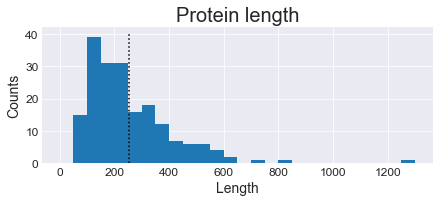

In [13]:
plt.figure(figsize=(7, 2.5))
plt.hist([len(protein['seq']) for protein in data], bins=np.linspace(0, 1300, 27))
plt.vlines(np.mean([len(protein['seq']) for protein in data]), 0, 40, linestyles='dotted')
setplot('Protein length', 'Length', 'Counts')

---
Since each amino acid is labeled as either epitope or not, we can also look at the number of epitopes per protein. The figure below shows that that distribution, like protein length, also varies. However, this distribution is less skewed, centered around 20 epitopes with a shorter tail.

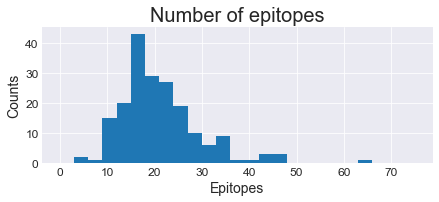

In [14]:
plt.figure(figsize=(7, 2.5))
plt.hist([sum(protein['epitope']) for protein in data], bins=np.linspace(0, 75, 26))
setplot('Number of epitopes', 'Epitopes', 'Counts')

---
The two observations that:
* Proteins vary quite a lot in length, and
* Not so much in number of epitopes,

together suggest that the frequency of epitopes in long proteins should be lower. This will turn out to be important information. We can visualize this with a simple scatterplot:

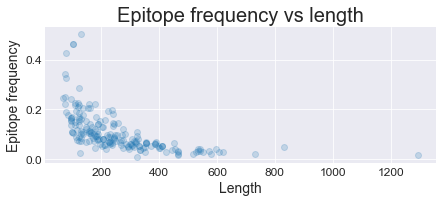

In [15]:
plt.figure(figsize=(7, 2.5))
plt.plot([len(i['epitope']) for i in data], [sum(i['epitope'])/len(i['epitope']) for i in data], 'o', alpha = 0.2)
setplot('Epitope frequency vs length', 'Length', 'Epitope frequency')

---
The physiochemical nature of the different 20 amino acids has a clear impact on the probability of it being an epitope. Below, the epitope frequency of the 20 amino acids is plotted in a barchart. The bars are colored according to the major chemical properties of a part of the amino acid, the side chain, at typical physiological temperatures and pH:

* Red: Negatively charged side chain
* Blue: Positively charged side chain
* Yellow: Neutral hydrophilic side chain
* Black: Hydrophobic side chain

From a basic protein chemistry viewpoint the distribution is as expected, but we will not delve into why in this report. Instead, we simply note that the amino acid type is an important determinant of epitope status.

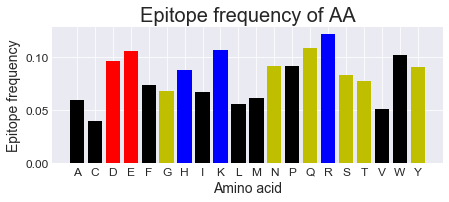

In [17]:
freq = [standata['epitopes'][standata['aa'] == i].mean() for i in range(1, 21)]
aasets = [('GSTYNQ', 'y'), # hydrophilic
         ('ACFILMVWP', 'k'), # hydrophobic
         ('DE', 'r'), # negative
         ('RHK', 'b')] # positive
aaindex = {i:n for n,i in enumerate("ACDEFGHIKLMNPQRSTVWY")}
plt.figure(figsize=(7, 2.5))
for aaset, color in aasets:
    for aa in aaset:
        plt.bar(aaindex[aa], freq[aaindex[aa]], color=color)
plt.xticks(range(len(freq)), "ACDEFGHIKLMNPQRSTVWY")
setplot('Epitope frequency of AA', 'Amino acid', 'Epitope frequency')

---
We also take a brief look at the output scores for BepiPred. First, let us compare BepiPred to random prediction. If BepiPred was no better than random, then mean scores for epitopes should not be higher than for non-epitopes. However, we see that is the case for all 20 amino acids.

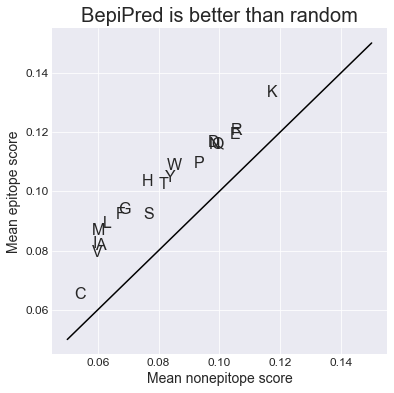

In [18]:
epmask = standata['epitopes'] == 1
mean_ep = [standata['scores'][epmask][standata['aa'][epmask] == i].mean() for i in range(1, 21)]
mean_nonep = [standata['scores'][~epmask][standata['aa'][~epmask] == i].mean() for i in range(1, 21)]
plt.figure(figsize=(6,6))
plt.plot([0.05, 0.15], [0.05, 0.15], color='k')
for x, y, letter in zip(mean_nonep, mean_ep, "ACDEFGHIKLMNPQRSTVWY"):
    plt.text(x, y, letter, fontsize=16)
setplot('BepiPred is better than random', 'Mean nonepitope score', 'Mean epitope score')

---
As already mentioned, BepiPred takes several features when making its prediction. However, on the plot below, we show on the x-axis the enrichment of each amino acid, i.e. the difference in epitope frequency vs. nonepitope frequency, and on the y-axis the mean BepiPred score for that amino acid. The high correlation of 0.89 means that most of the predictive power of BepiPred simply comes from adjusting the prediction for the amino acid identity. In other words, a predictor that simply predicts the epitope probability based on only the amino acid identity would only be marginally worse than BepiPred.

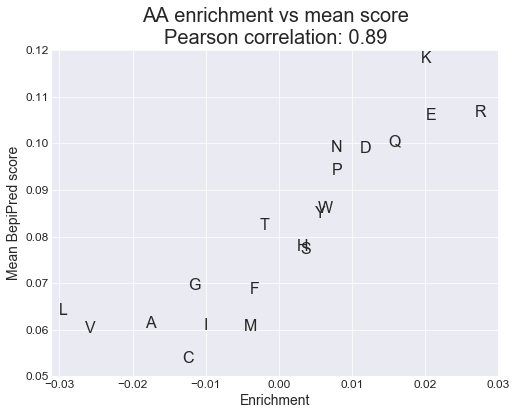

In [19]:
enrichments = list()
for aa in range(1, 21):
    epitope_freq = (standata['aa'][epmask] == aa).mean()
    non_epitope_freq = (standata['aa'][~epmask] == aa).mean()
    enrichment = epitope_freq - non_epitope_freq
    enrichments.append(enrichment)
    
mean_scores = [standata['scores'][standata['aa'] == i].mean() for i in range(1, 21)]
plt.figure(figsize=(8, 6))

for x, y, letter in zip(enrichments, mean_scores, "ACDEFGHIKLMNPQRSTVWY"):
    plt.text(x, y, letter, fontsize=16)
    
plt.xlim(-0.031, 0.03)
plt.ylim(0.05, 0.12)
correlation = np.corrcoef(enrichments, mean_scores)[0,1]
setplot('AA enrichment vs mean score\nPearson correlation: {:.2f}'.format(correlation),
        'Enrichment', 'Mean BepiPred score')

## Analysis

To re-iterate, in our analysis we will build a series of models to improve Bepipred's predictions. In this section, we will present each model, fit it, and print the pareto-smoothed importance sampling leave one out cross validation loglikelihood (PSIS-LOO) for each. In later sections we will do a more thorough comparison of the different models, including looking at diagnostic criteria.

Because these models take a long time to run for a useful number of iterations with about 48,000 samples, we will not run the models in this notebook. Instead, we will load in saved data from previous runs. However, the code for running the models can be found at the end of the notebook.

### A brief note on priors

One of the strengths of Bayesian data analysis is that it allows us to specify prior distributions. Prior distributions allow informing the data with prior knowledge, which influence the final result, such that the final result becomes a weighted compromise between the prior and the data. In our analysis, we have chosen to use the flat, default priors of Stan. This means that we do not use prior information to form the final result.

The benefit of not specifying a prior is that it simplifies our models, so that they run faster. We have no strong prior beliefs about the parameters of any of our models, so any explicit prior we could have chosen would have had to be relatively flat. Furthermore, we have a lot of data - about 48,000 observations, so adding explicit priors would not affect the result in any significant way.

### Load results from models

Here, I load the results, i.e MCMC trails and diagnostics, from each model (except null model and model 0, which are much simpler). We have cached them to avoid having to run all models in this notebook;

In [280]:
caches = dict()
for n in range(1, 8):
    file = np.load('cache2/model_{n}.npz'.format(n=n))
    caches[n] = dict(file.items())
    file.close()

#### Null model

For a baseline, we simply predict a constant probability of each amino acid being an epitope. Hopefully, all models should perform better than this.

Because this model is not fitted with Stan, we do not run PSIS-LOO, and will use the direct loglikelihood instead. We note that this is not rigorous. However, since the purpose of PSIS-LOO is to adjust the loglikelihood according to the variability of the model, and this model has only one parameter which is almost completely invariant under leave-one-out cross validation, the actual difference between the loglikelihood and the PSIS-LOO will be insignificant. In other words, we consider this reported log likelihood to be a more accurate estimate of the true goodness-of-fit of this particular model than the PSIS-LOO is for the other models with more effective parameters.

$epitopes \sim uniform(\alpha)$

In [281]:
n_epitopes = sum(standata['epitopes'])
logps = np.array([log(1 - n_epitopes / standata['n_aa']), log(n_epitopes / standata['n_aa'])])
model_null_loglik = logps[standata['epitopes']].sum()
print("Loglikelihood (PSIS-LOO): {:.2f}".format(model_null_loglik))

Loglikelihood (PSIS-LOO): -13544.84


#### Model 0: Bepipred model

As the purpose of our project is to enhance Bepipred's prediction, the second baseline to establish is a model which simply interpretates Bepipreds output scores as probabilities. Building a model to beat the performance of this baseline is the true goal of the project.

Again, for this model we will use loglikelihood as an extremely close approximation to the PSIS-LOO.

$epitopes \sim uniform(predictions)$

In [282]:
model_0_loglik = np.empty((1, len(standata['scores'])), dtype=np.float32)
mask = standata['epitopes'] == 1
model_0_loglik[0, mask] = np.log(standata['scores'][mask])
model_0_loglik[0, ~mask] = np.log(1 - standata['scores'][~mask])

# No sampling, so we use the loglikelihood
print("Loglikelihood (PSIS-LOO): {:.2f}".format(model_0_loglik.sum()))

Loglikelihood (PSIS-LOO): -12883.65


#### Model 1: Logistic model

Bepipred is a deep neural network, and is therefore fitted to minimize some loss function which is not necessarily related to the log likelihood. The next step towards a probabilistic model is a simple logistic regression that uses only Bepipreds output to calculate a probability of an amino acid being an epitope.

We expected that this would result in a lower loglikelihood than model 0.

$epitopes \sim BernoulliLogit(\alpha + \beta \times predictions)$

Our implemented Stan model looks like the following:

In [283]:
# open model
with open('models/pooled.stan') as f:
    model_1_code = f.read()
print(model_1_code)

def model1(i):
    alpha = caches[1]['alpha'][i]
    beta = caches[1]['beta'][i]
    return expit(alpha + beta * standata['scores'])

data {
    int<lower=0> n_aa;
    int<lower=0,upper=1> epitopes[n_aa]; // binarize to 0 or 1
    vector[n_aa] scores; // output of bepipred
}
parameters {
    real alpha;
    real beta;
}
model {
    epitopes ~ bernoulli_logit(alpha + beta * scores);
}



---
This model is unique in that the number of parameters is so small that we can plot the posterior draws directly:

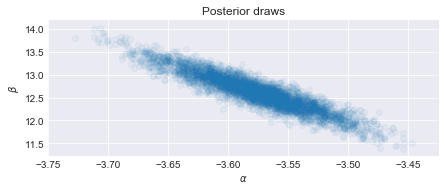

In [284]:
# Posterior sampling
plt.figure(figsize=(7, 2.5))
plt.scatter(caches[1]['alpha'], caches[1]['beta'], alpha = 0.05)
plt.title('Posterior draws')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.show()

There is a small "island" of samples around [-3.45, 11.5], but otherwise it looks nice and converged.

According to the PSIS-LOO value, this model performed worse than the Bepipred model (model 0). This might suggest that logistic models are not enitrely suitable for this problem. However, in order to build more complex models, we elected to continue with logistic models, as we can simply add more linear terms to the model.

#### Model 2: Separate model

The separate model does not include any pooling and will generate an estimate for each amino acid. This model will treat the amino acids independently from each other, means each amino acid estimate is unbiased and only based on its own score. This model has two parameters ($\alpha$ and $\beta$) for each amino acid estimate.

$epitopes \sim expit(\alpha_{aa} + \beta_{aa} \times pred)$

In [2]:
with open("models/separate.stan") as file:
    model_2_code = file.read()
print(model_2_code)

def model2(i):
    aa = standata['aa'] - 1
    alpha = caches[2]['alpha'][i][aa]
    beta = caches[2]['beta'][i][aa]
    return expit(alpha + beta * standata['scores'])

data {
    int<lower=0> n_classes;                    // No. of unique amino acids in the sequence
    int<lower=0> n_aa;                         // Total number of amino acids
    int aa[n_aa];                              //
    int<lower=0,upper=1> epitopes[n_aa];       // Binarize to 0 or 1
    vector[n_aa] scores;                       // Output of bepipred
}

parameters {
    vector[n_classes] alpha;
    vector[n_classes] beta;
}

model {
    epitopes ~ bernoulli_logit(alpha[aa] + beta[aa] .* scores);
}



#### Model 3: Hierarchical model

This model is an extension of the previous, where we assume the different $\alpha$ values are not truly independent, but in fact related by being from the same distribution, and thus can inform each other. Further, when creating this model, we assumed that the different amino acids would have larger variance in $\alpha$ than in $\beta$. This was clearly wrong.

$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$

$epitopes \sim expit(\alpha_{aa} + \beta \times pred)$

In [286]:
with open('models/hierarchical.stan') as file:
    model_3_code = file.read()
print(model_3_code)

def model3(i):
    aa = standata['aa'] - 1
    alpha = caches[3]['alpha'][i][aa]
    beta = caches[3]['beta'][i]
    return expit(alpha + beta * standata['scores'])

data {
    int<lower=0> n_classes;
    int<lower=0> n_aa;
    int aa[n_aa];
    int<lower=0,upper=1> epitopes[n_aa]; // binarize to 0 or 1
    vector[n_aa] scores; // output of bepipred
    
}
parameters {
    real alpha_mu;
    real<lower=0> alpha_sigma;
    real beta;
    vector[n_classes] alpha;
    
}
model {
    alpha ~ normal(alpha_mu, alpha_sigma);
    epitopes ~ bernoulli_logit(alpha[aa] + beta * scores);
}



---
Note that in fitting this model, we have set `adapt_delta` up from the default of 0.8 to 0.9. We have done this to avoid that some iterations would end in divergence, as would otherwise happen. Increasing the value of this parameter forces the MCMC to take smaller steps, which may allow it to explore the space more reliably, though less effectively.
The fact that this happens is another suggestion that a hierarchical model is not a good fit.

#### Model 4: Hierarchical model + length

This model is identical to the previous model, except that a term is added to the logistic regression which takes the length of the protein into account.

As was shown in the data exploration section, long proteins have fewer epitopes per amino acid than short ones do. The signal is remarkable, and because Bepipred predicts on only a small window of amino acids, and is therefore unable to integrate information across the entire protein we believe it is not able to take this into account. We therefore expect this model to perform significantly better.

$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$

$epitopes \sim expit(\alpha_{aa} + \beta \times pred + \gamma \times \frac{1}{length})$

In [287]:
with open("models/length.stan") as file:
    model_4_code = file.read()
print(model_4_code)

def model4(i):
    aa = standata['aa'] - 1
    alpha = caches[4]['alpha'][i][aa]
    beta = caches[4]['beta'][i]
    gamma = caches[4]['gamma'][i]
    return expit(alpha + beta * standata['scores'] + gamma * standata['inv_length'])

data {
    int<lower=0> n_classes;
    int<lower=0> n_aa;
    int aa[n_aa];
    int<lower=0,upper=1> epitopes[n_aa]; // binarize to 0 or 1
    vector[n_aa] scores; // output of bepipred
    vector[n_aa] inv_length; // length of protein of aa
    
}
parameters {
    real alpha_mu;
    real<lower=0> alpha_sigma;
    real beta;
    vector[n_classes] alpha;
    real gamma;
    
}
model {
    alpha ~ normal(alpha_mu, alpha_sigma);
    epitopes ~ bernoulli_logit(alpha[aa] + beta * scores + gamma * inv_length);
}


#### Model 5: Hierarchical model + sum of scores

This model is similar to the previous one, except the $\gamma$ parameter compensates for the sum of scores in the protein, rather than the length.

We believe the reason longer proteins have relatively fewer epitopes is that the number of epitopes is relatively invariant across proteins. If this is the case, then a protein with a high sum of scores would need a stronger negative correction than a merely long protein with lower sum of scores. In a sense, the previous model can be considered just an approximation of this model, as the true purpose of the compensation is to limit the number of predicted epitopes.

$\alpha \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$

$epitopes \sim expit(\alpha_{aa} + \beta \times pred + \gamma \times \frac{1}{\sum{pred}})$

In [288]:
with open("models/scores.stan") as file:
    model_5_code = file.read()
print(model_5_code)

def model5(i):
    aa = standata['aa'] - 1
    alpha = caches[5]['alpha'][i][aa]
    beta = caches[5]['beta'][i]
    gamma = caches[5]['gamma'][i]
    return expit(alpha + beta * standata['scores'] + gamma * standata['inv_score_sum'])

data {
    int<lower=0> n_classes;
    int<lower=0> n_aa;
    int aa[n_aa];
    int<lower=0,upper=1> epitopes[n_aa]; // binarize to 0 or 1
    vector[n_aa] scores; // output of bepipred
    vector[n_aa] inv_score_sum; // Inverse of sum of scores in protein
    
}
parameters {
    real alpha_mu;
    real<lower=0> alpha_sigma;
    real beta;
    vector[n_classes] alpha;
    real gamma;
    
}
model {
    alpha ~ normal(alpha_mu, alpha_sigma);
    epitopes ~ bernoulli_logit(alpha[aa] + beta * scores + gamma * inv_score_sum);
}


#### Model 6: Separate model + sum of scores

We saw that model 2 outperformed model 3, because our initial assumptions behind the hierarchical model were dubious, and we have sufficient data to fit more parameters. We have also seen that the inclusion of the sum of scores makes model 5 more accurate than model 3 or model 4.

This model is simply a combination of model 2 and model 5. We expect this to be even better than the previous:

$epitopes \sim expit(\alpha_{aa} + \beta_{aa} \times pred + \gamma \times \frac{1}{\sum{pred}})$

In [289]:
with open("models/separate_scoresum.stan") as file:
    model_6_code = file.read()
print(model_6_code)

def model6(i):
    aa = standata['aa'] - 1
    alpha = caches[6]['alpha'][i][aa]
    beta = caches[6]['beta'][i][aa]
    gamma = caches[6]['gamma'][i]
    return expit(alpha + beta * standata['scores'] + gamma * standata['inv_score_sum'])

data {
    int<lower=0> n_classes;
    int<lower=0> n_aa;
    int aa[n_aa];
    int<lower=0,upper=1> epitopes[n_aa]; // binarize to 0 or 1
    vector[n_aa] scores; // output of bepipred
    vector[n_aa] inv_score_sum; // Inverse of sum of scores in protein
    
}
parameters {
    vector[n_classes] alpha;
    vector[n_classes] beta;
    real gamma;
    
}
model {
    epitopes ~ bernoulli_logit(alpha[aa] + beta[aa] .* scores + gamma * inv_score_sum);
}


#### Model 7: Model 5 w/o Bepipred

Since we can see such a marked improvement at the addition of a factor compensating for protein length, it is interesting to see how a model that uses only the amino acid identity and the sum of lengths compares to Bepipred:

$epitopes \sim expit(\alpha_{aa} + \gamma \times \frac{1}{\sum{length}})$

In [290]:
with open("models/linear.stan") as file:
    model_7_code = file.read()
print(model_7_code)

def model7(i):
    aa = standata['aa'] - 1
    alpha = caches[7]['alpha'][i][aa]
    gamma = caches[7]['gamma'][i]
    return expit(alpha + gamma * standata['inv_length'])

data {
    int<lower=0> n_classes;
    int<lower=0> n_aa;
    int aa[n_aa];
    int<lower=0,upper=1> epitopes[n_aa]; // binarize to 0 or 1
    vector[n_aa] inv_length; // Inverse of protein length
    
}
parameters {
    vector[n_classes] alpha;
    real gamma;
    
}
model {
    epitopes ~ bernoulli_logit(alpha[aa] + gamma * inv_length);
}


## Overview of results

First, let us make sure the diagnostic criteria are such that we can trust the results of the Markov chain monte carlo (MCMC).

The first criteria is $\hat{R}$, a measure of the ratio between the between- and within-chain variance. If the chains have converged to the same distribution, the chains will be interchangable, and this ratio will be close to 1, say < 1.1.

The plot below shows that the values of $\hat{R}$ for all models are quite close to 1, meaning the models have converged succesfully. A slight peculiarity is that model 3 and 6 have an $\hat{R}$ smaller than 1 for most parameters. This is probably because of anticorrelation within each chain, which means the variance will be somewhat overestimated.

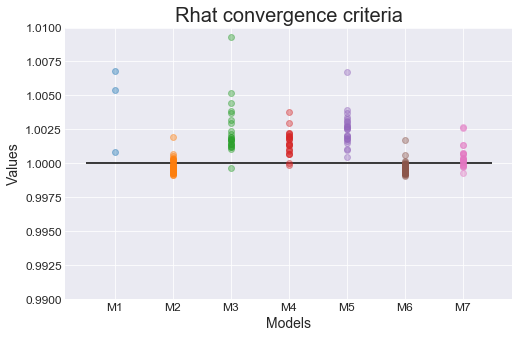

In [291]:
plt.figure(figsize=(8, 5))
plt.hlines(1, 0.5, 7.5)
for model in range(1, 8):
    rhat_col = np.where(caches[model]['summary_colnames'] == 'Rhat')[0][0]
    ys = caches[model]['summary'][:,rhat_col]
    plt.plot([model]*len(ys), ys, 'o', alpha=0.4)
setplot('Rhat convergence criteria', 'Models', 'Values')
plt.ylim(0.99, 1.01)
plt.xticks(range(1, 8), ['M'+str(i) for i in range(1, 8)]);

Next, we plot the effective sample size $N_{eff}$. Autocorrelation in the chain means that the sames are not truly independent. Thus, the effective number of samples are less than the actual number of samples. In contrast, anticorrelation can lead to an effective sample size that is larger than the actual sample size. The effective number can be estimated by calculating the chain autocorrelation.

In the plot below, we see that the number of effective parameters. Upon looking closer, it appears to be a scaled mirror-image of the $\hat{R}$ plot above: The same models that have a low $\hat{R}$ have a high number of effective parameters. Again, this is due to correlation/anticorrelation within each chain: Difficulty in moving through parameter space leads to correlated chains, which lead to both a higher $\hat{R}$ and a lower $N_{eff}$.

As a side note, it is rare, but sometimes observed that $N_{eff}$ can exceed the number of samples. This usually happens because the NUTS sampler is able to sample the next point futher from the starting point than a truly random sampler. 

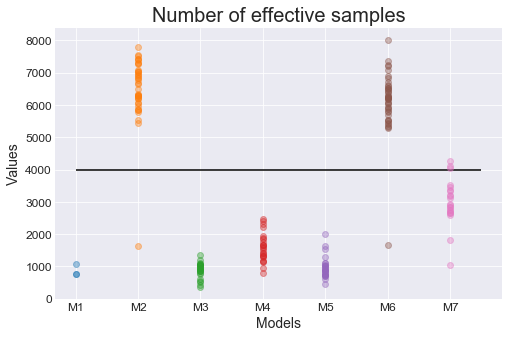

In [292]:
plt.figure(figsize=(8, 5))
plt.hlines(4000, 1, 7.5)
for model in range(1, 8):
    neff_col = np.where(caches[model]['summary_colnames'] == 'n_eff')[0][0]
    ys = caches[model]['summary'][:,neff_col]
    plt.plot([model]*len(ys), ys, 'o', alpha=0.4)
setplot('Number of effective samples', 'Models', 'Values')
plt.xticks(range(1, 8), ['M'+str(i) for i in range(1, 8)]);

As a sanity check, we can also plot the number of effective parameters. If parameters are highly correlated with each other, the degrees of freedom are in fact fewer than a naïve estimate based solely on the number of parameters might lead one to believe. The effective number of parameters may be calculated by looking at the dependency between different parameters.

The plot below is quite unremarkable:

Model 1 and 7 have a similar number of effective and real parameters, because there is literally no depedency between the parameters. 

The hierarchical models, model 3, 4 and 5, have a significantly lower number of effective parameters by virtue of the model itself: The model explicitly says that the different $\alpha$ parameters have been drawn from the same distribution and are therefore not independent.

The separate models, model 2 and 6 also have a lower number of effective parameters than the number of real parameters. This is almost certainly because the $\alpha$ and $\beta$ values are not independent for each amino acid, but rather depends strongly on each other - i.e. a high $\alpha$ necessitates a lower $\beta$.

This plot merely shows that there are no nasty surprises in how our model is fitted to the data, and they work as expected.

In [293]:
# Calculate the loglikelihood matrix for each model
loglike_matrices = list()
for model in range(1, 8):
    loglike_mat = loglik_matrix(eval('model' + str(model)), caches[model], standata)
    loglike_matrices.append(loglike_mat)
    
# Calculate the PSIS-LOO
loos, ks = list(), list()
for matrix in loglike_matrices:
    loo, _, k = psis.psisloo(matrix)
    loos.append(loo)
    ks.append(k)

p_nominal = [0, 0, 2, 40, 23, 24, 24, 41, 21]
# Calculate effective paramters
peffs = [1, 1] # First two models have 1 parameter each
for loo, matrix in zip(loos, loglike_matrices):
    peffs.append(p_eff(loo, matrix))

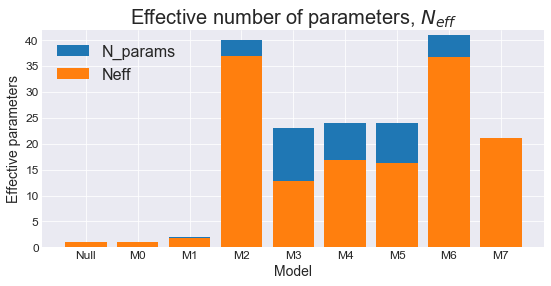

In [298]:
plt.figure(figsize=(9, 4))
plt.bar(range(len(peffs)), p_nominal)
plt.bar(range(len(peffs)), peffs)

plt.ylim(0, 42)
plt.xticks(range(len(peffs)), ['Null'] + ['M'+str(i) for i in range(8)])
setplot('Effective number of parameters, $N_{eff}$', 'Model', 'Effective parameters')
plt.legend(['N_params', 'Neff'], fontsize=16)

The pareto tail index is a measure of the distribtion of the parameters of the single observations. If this index is too high, then single observations stand out more. This is an indication that the PSIS-LOO, mentioned below, is over-optimistic, because the observed population is likely not representative of the true population, and the parameters of the model therefore have been overfitted.

As a rule of thumb, if the pareto tail indices are > 0.7 for any parameter, the estimate of the PSIS-LOO is likely off. In the plot below, the maximal value for each model is indicated with a dotted line. It is clear that no parameter is near 0.7, and the PSIS-LOO estimates are therefore *likely* reliable.

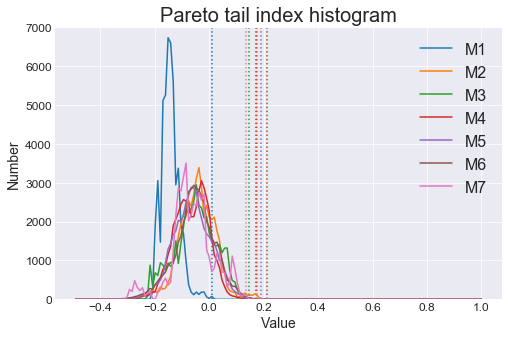

In [304]:
plt.figure(figsize=(8,5))
xs = np.linspace(-0.5, 1, 160)
for j, i in enumerate(ks):
    y, x = np.histogram(i, xs)
    plt.plot(xs[1:], y)
    plt.vlines(max(i), 0, 7000, color='C'+str(j), linestyles='dotted')
setplot("Pareto tail index histogram", 'Value', 'Number')
plt.ylim(0, 7000)
plt.legend(['M' + str(i) for i in range(1,8)], fontsize=16)

With all the diagnostics indicating reasonable covergence and that the values of the parameters can be accurately estimated, the most central issue can be investigated: Which model is the best fit?

In this project, we use Pareto smoothed importance sampling leave-one-out (PSIS-LOO) cross-validation to judge the different models. PSIS-LOO attempts to estimate the generalized loglikelihood of the model by taking the variability of the model into account. This is done by penalizing models with more effective parameters, and by using cross-validation to estimate the performance of the model on unseen data.

In the plot below, we can see the null model performs worst, as expected. Unexpectedly, model 0 outperforms models 1-3. The fact that model 0 outperforms model 1, despite model 1 being an extension of model 0, is troubling. We believe it points to a fundamental problem with using the `bernoulli_logit` distribution based on the BepiPred scores to model epitopes. If this model type was a good fit for the problem, then model 1 should have found parameters which made it at least as good as model 0.

Model 1, 2 and 3 are close in performance, with model 2 winning out slightly. We should note that with out very large number of observations (> 48,000), there is little lost in building a model with more parameters, as model 2 has.

Model 4 is the first model to see an improvement over model 0. This confirms our suspicion that to improve BepiPred, we have to add information that BepiPred is not already using - in this case the length of the protein.

The improved performance of model 5 over model 4 lends at least some credence to our hypothesis that the inverse correlation between length and epitope frequency is simply a consequence of proteins having a more-or-less constant number of epitopes. Hence, model 5 more accurately takes an estimated overabundance of epitopes into account than model 4 does.

Similar to model 2 being slightly better than model 3, we see model 6 being slightly better than model 5. This is for the same reason, as model 3 and 5 are both hierarchical models, whereas 2 and 6 are separate models.

Lastly, model 7 is worse than models 4 to 7. Interestingly, however, model 7 outperforms model 0. It is noteworthy that that the complicated BepiPred neural network in fact predicts less well than a simple linear model using only protein length and amino acid identity.

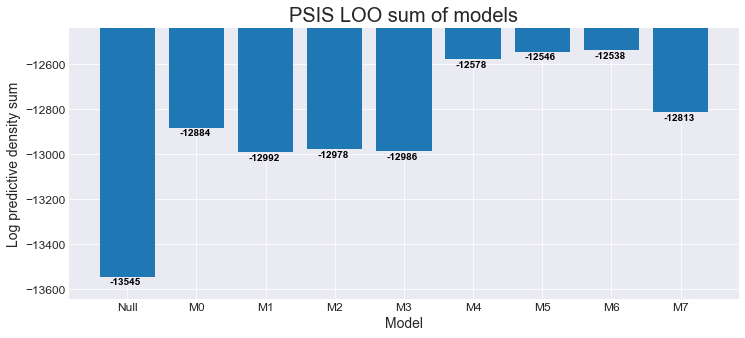

In [312]:
plt.figure(figsize=(12, 5))
plotloos = [model_null_loglik, model_0_loglik.sum()] + loos
plt.bar(range(len(plotloos)), plotloos)
for i, v in enumerate(plotloos):
    plt.text(i - .25, v - 35, str(r'{:.0f}'.format(v)), color='black', fontweight='bold', fontsize=10)
plt.ylim(min(plotloos) - 100, max(plotloos) + 100)
plt.xticks(range(len(plotloos)), ['Null'] + ['M'+str(i) for i in range(8)])
setplot('PSIS LOO sum of models', 'Model', 'Log predictive density sum')

Finally, because our model is a calibration model, that is, our output is probabilities rather than events, we may check whether our models are well-calibrated by making a calibration plot. In a calibration plot, we plot the predicted probability of a group of predictions against the actual frequency of happening. In a well-calibrated plot, these should be approximately the same.

Below, we plot both our model 6 (blue), as well as BepiPred's raw scores (orange). We see that both BepiPred and model 6 appear to show some bias at both low predicted probability and high predicted probability, where the true probability is in fact lower than the predicted. However, at the high predicted probabilities, model 6 seem to have less bias than BepiPred. Furthermore, the highest 5% predicted scores of model 6 were significantly higher than BepiPreds (~0.27 vs 0.17) - this means model 6 is able to make more confident predictions than BepiPred.

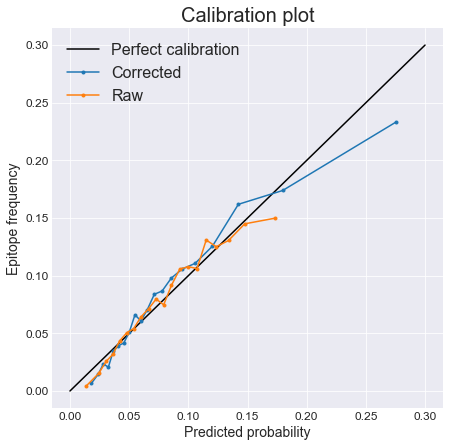

In [323]:
corrected_preds = np.empty((len(caches[6]['gamma']), len(standata['aa'])), dtype=np.float32)
for i in range(len(corrected_preds)):
    corrected_preds[i,:] = model6(i)
corrected_preds = corrected_preds.mean(axis=0)

plt.figure(figsize=(7,7))
plt.plot([0,0.3], [0, 0.3], color='k')
setplot("Calibration plot", "Predicted probability", "Epitope frequency")

nbuckets = 20
for xsource, ysource in (corrected_preds, standata['epitopes']), (standata['scores'], standata['epitopes']):
    indices = np.argsort(xsource)
    sorted_x, sorted_y = xsource[indices], ysource[indices]
    
    start = 0
    xmeans, ymeans = list(), list()
    for bucket in range(nbuckets):
        end = start + (len(sorted_x) // nbuckets) + 1
        xmeans.append(sorted_x[start:end].mean())
        ymeans.append(sorted_y[start:end].mean())
        start = end
        
    plt.plot(xmeans, ymeans, '.-')
plt.legend(['Perfect calibration', 'Corrected', 'Raw'], fontsize=16)

## Conclusion

Predicting epitope regions remains a challenging task. In this project we were able to show that BepiPred's performance can be improved by incorporating Bayesian modeling. Due to its poor performance, we found that a logistic model (model 1) is not the model of choice for this type of problem. As demonstrated in this project, a simple linear model (but also more sophisticated models) can improve epitope prediction by adding information that BepiPred is not already using, such as protein length and amino acid identity. By including even more data and/or having more elaborate models, we expect to increase the epitope prediction performance even further.

## Appendix

### Running and saving the models:

In [263]:
os.mkdir('cache2')

model_1 = pystan.StanModel(model_code=model_1_code, model_name='Model_1')
fit_model_1 = model_1.sampling(data=standata)
extract_1 = fit_model_1.extract()
np.savez_compressed('cache2/model_1.npz', **extract_1, **fit_model_1.summary())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_1_16473ccc58d6ccdd3f35e7f8c8a0e157 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpgjhal2a3/stanfit4Model_1_16473ccc58d6ccdd3f35e7f8c8a0e157_6436669930650260530.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [266]:
model_2 = pystan.StanModel(model_code=model_2_code, model_name='Model_2')
fit_model_2 = model_2.sampling(data=standata)
extract_2 = fit_model_2.extract()
np.savez_compressed('cache2/model_2.npz', **extract_2, **fit_model_2.summary())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_2_083d69cdabb3d73c3eacf2102b1b65d3 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmp34x8ncrg/stanfit4Model_2_083d69cdabb3d73c3eacf2102b1b65d3_1841387027272749439.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [267]:
model_3 = pystan.StanModel(model_code=model_3_code, model_name='Model_3')
fit_model_3 = model_3.sampling(data=standata, control=dict(adapt_delta=0.9))
extract_3 = fit_model_3.extract()
np.savez_compressed('cache2/model_3.npz', **extract_3, **fit_model_3.summary())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_3_9beacc40e8e5857606d3cea102b2c607 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpqkdohtsp/stanfit4Model_3_9beacc40e8e5857606d3cea102b2c607_3245029643645338531.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [275]:
model_4 = pystan.StanModel(model_code=model_4_code, model_name='Model_4')
fit_model_4 = model_4.sampling(data=standata, control=dict(adapt_delta=0.9))
extract_4 = fit_model_4.extract()
np.savez_compressed('cache2/model_4.npz', **extract_4, **fit_model_4.summary())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_4_e6d7604dde986c5d3c860dc5a5f6467a NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpalmfmsr6/stanfit4Model_4_e6d7604dde986c5d3c860dc5a5f6467a_2631959414243913885.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [276]:
model_5 = pystan.StanModel(model_code=model_5_code, model_name='Model_5')
fit_model_5 = model_5.sampling(data=standata, control=dict(adapt_delta=0.9))
extract_5 = fit_model_5.extract()
np.savez_compressed('cache2/model_5.npz', **extract_5, **fit_model_5.summary())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_5_490012f8c1fdc2841978a4954bfdc2cc NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpwe8hx0y_/stanfit4Model_5_490012f8c1fdc2841978a4954bfdc2cc_8922010814031840706.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [277]:
model_6 = pystan.StanModel(model_code=model_6_code, model_name='Model_6')
fit_model_6 = model_6.sampling(data=standata)
extract_6 = fit_model_6.extract()
np.savez_compressed('cache2/model_6.npz', **extract_6, **fit_model_6.summary())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_6_ccf4d7a0d4c0c635667dfef7910aeb6e NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmps5q4xz15/stanfit4Model_6_ccf4d7a0d4c0c635667dfef7910aeb6e_5240490907992913826.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [278]:
model_7 = pystan.StanModel(model_code=model_7_code, model_name='Model_7')
fit_model_7 = model_7.sampling(data=standata)
extract_7 = fit_model_7.extract()
np.savez_compressed('cache2/model_7.npz', **extract_7, **fit_model_7.summary())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_7_e52c19e55a7805f4a3b1270ae410bd62 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpfqwealjs/stanfit4Model_7_e52c19e55a7805f4a3b1270ae410bd62_8791542248764542542.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
